In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

register_matplotlib_converters()

# Generate Some Data

# $y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$
# $\varepsilon_t \sim N(0,1)$

In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
date_index = pd.date_range(start="9/1/2019", end="1/1/2020")

In [4]:
mu = 50
series = []
for t in range(1, len(date_index) + 1):
    series.append(mu + 0.4 * errors[t - 1] + 0.3 * errors[t - 2] + errors[t])

In [5]:
series = pd.Series(series, date_index)
series = series.asfreq(pd.infer_freq(series.index))

In [32]:
series

2019-09-01    48.904929
2019-09-02    48.835690
2019-09-03    49.718102
2019-09-04    50.419764
2019-09-05    51.227311
                ...    
2019-12-28    50.579029
2019-12-29    49.677921
2019-12-30    48.863291
2019-12-31    50.331236
2020-01-01    50.390033
Freq: D, Length: 123, dtype: float64

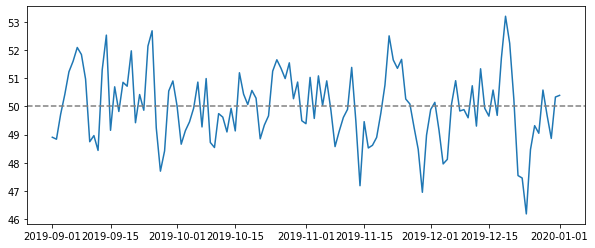

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.axhline(mu, linestyle="--", color="grey")

In [7]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

# ACF

<BarContainer object of 10 artists>

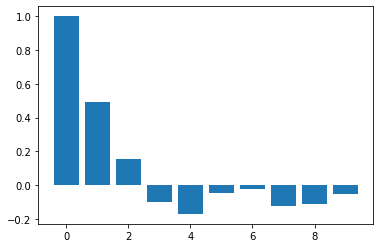

In [8]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

# PACF

<BarContainer object of 25 artists>

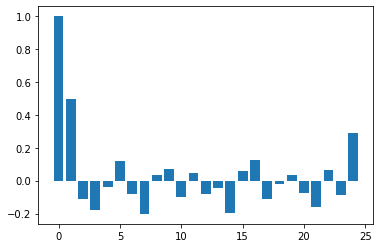

In [18]:
num_lags = 25
pacf_vals = pacf(series, num_lags)
plt.bar(range(num_lags), pacf_vals[:num_lags])

# Get training and testing sets

In [19]:
train_end = datetime(2019, 12, 30)
test_end = datetime(2020, 1, 1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1) : test_end]

# Fit ARIMA Model

In [22]:
# create the model
model = ARIMA(train_data, order=(0, 0, 2))

In [23]:
# fit the model
model_fit = model.fit()

In [24]:
# summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -182.084
Date:                Tue, 25 Oct 2022   AIC                            372.167
Time:                        14:05:50   BIC                            383.350
Sample:                    09-01-2019   HQIC                           376.709
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9576      0.181    276.755      0.000      49.604      50.311
ma.L1          0.4925      0.083      5.906      0.000       0.329       0.656
ma.L2          0.3014      0.093      3.253      0.0

# Predicted Model:
# $\hat{y}_t = 50 + 0.49\varepsilon_{t-1} + 0.30\varepsilon_{t-2}$

In [25]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [31]:
pred_start_date, pred_end_date

(Timestamp('2019-12-31 00:00:00', freq='D'),
 Timestamp('2020-01-01 00:00:00', freq='D'))

In [26]:
# get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [27]:
residuals = test_data - predictions

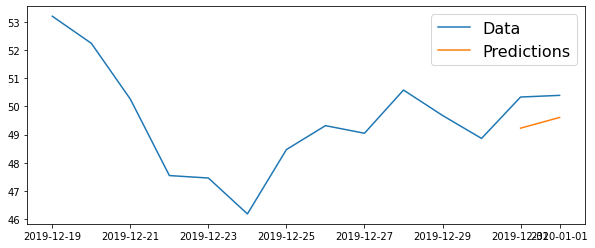

In [28]:
plt.figure(figsize=(10, 4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(("Data", "Predictions"), fontsize=16)

In [29]:
print("Mean Absolute Percent Error:", round(np.mean(abs(residuals / test_data)), 4))

Mean Absolute Percent Error: 0.0187


In [30]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.9571863550279703
